# Exam exercise

## Higgs Boson

In the [Standard Model of Particle Physics](https://en.wikipedia.org/wiki/Standard_Model), particles not only make up the things that we see, but also their interactions (aka the forces, with the notable exception of gravity). 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Standard_Model_of_Elementary_Particles.svg/800px-Standard_Model_of_Elementary_Particles.svg.png)




Not only that, but the very fact that particles acquire mass is also regarded as an interaction. The particle responsible for that is called Higgs Boson. [Discovered in 2012](https://atlas.cern/Discover/Physics/Higgs) it was the last of these particles to be observed and completed the puzzle above (a puzzle that now is almost too complete!).

This amazing discovery needed the massive facility LHC at Cern (Geneva). The idea is to collide very energetic particles and hope that the particle you want comes out of the collision:

![](https://cds.cern.ch/images/CERN-MI-0807031-01/file?size=large)

![](https://cds.cern.ch/images/CERN-EX-0511013-01/file?size=large)


From a data-analysis perspective, results look like this:


![](https://cms.cern/sites/default/files/field/image/image1_1.png)

In this case they looked collisions which have to photons ($\gamma$) as products. Most of these collisions are made by something else, but a small fraction of them is due to the Higgs boson ($H$). 

So we have a background (that powerlaw-like feature) and then a tiny signal (that gaussian-like feature).

Now, say you've collected this data (which is my own simulation of the above process):

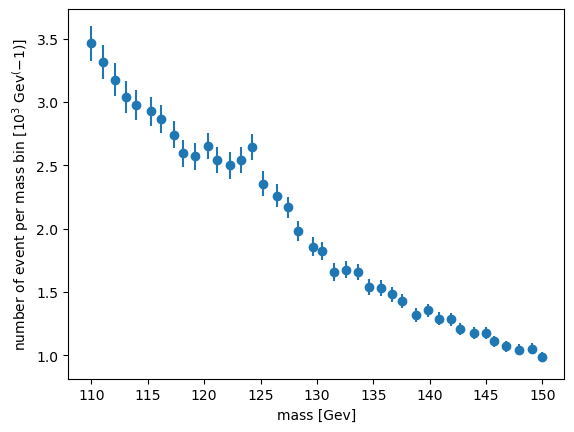

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mass, eventpermassbin, eventerr = np.loadtxt('datasets/boson.txt',unpack=True)

plt.errorbar(mass, eventpermassbin, eventerr,fmt='o')

plt.xlabel('mass [Gev]')

plt.ylabel('number of event per mass bin [$10^3$ Gev$^(-1)$]');

### Your tasks: 

**Given these data, it the Higgs boson truly there?**

- Come up with a model for both the background and the supposed signal (hint: read above)
- Write down the likelihood and your priors.
- Run an MCMC *assuming that the signal is there* and estimate the parameters of both signal and background.
- Identify the parameter in your model that is equal to zero when the signal is absent.
- Build a density estimator (you decide which one!) on the marginalized posterior distribution of that parameter.
- Evaluate the Bayes factor in favor of the signal using the Savage-Dickey trick.
- Use the Jeffrey's scale. Did you discover the Higgs boson?

## Resolution

We must combine two models: a power-law model (background) and a gaussian model (signal)

In [6]:
import arviz as az
import corner 
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

In [ ]:
data = np.loadtxt('datasets/boson.txt', unpack=True)
x_values = data[0] 
y_values = data[1]
errs_values = data[2]

In [5]:
with pm.Model() as model:
    x = pm.Data("x", x_values)
    y = pm.Data("y", y_values)
    errs = pm.Data("errs", errs_values)

    # Powerlaw priors
    a = pm.HalfNormal("a", sigma=10)
    k = pm.Normal("k", mu=2.0, sigma=1)
    x_0 = pm.Normal("x_0", mu=110, sigma=5)

    background = a * (x - x_0)**(-k)

    # Gaussian priors
    amp = pm.Normal("amp", sigma=5)
    mu = pm.Normal("mu", mu=125, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.8)

    signal = amp * pm.math.exp(-(x - mu)**2 / (2 * sigma**2))

    # Model
    y_model = background + signal

    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=y_model, sigma=errs, observed=y)

    trace = pm.sample(10000, tune=2000, target_accept=0.95, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, k, x_0, amp, mu, sigma]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 261 seconds.


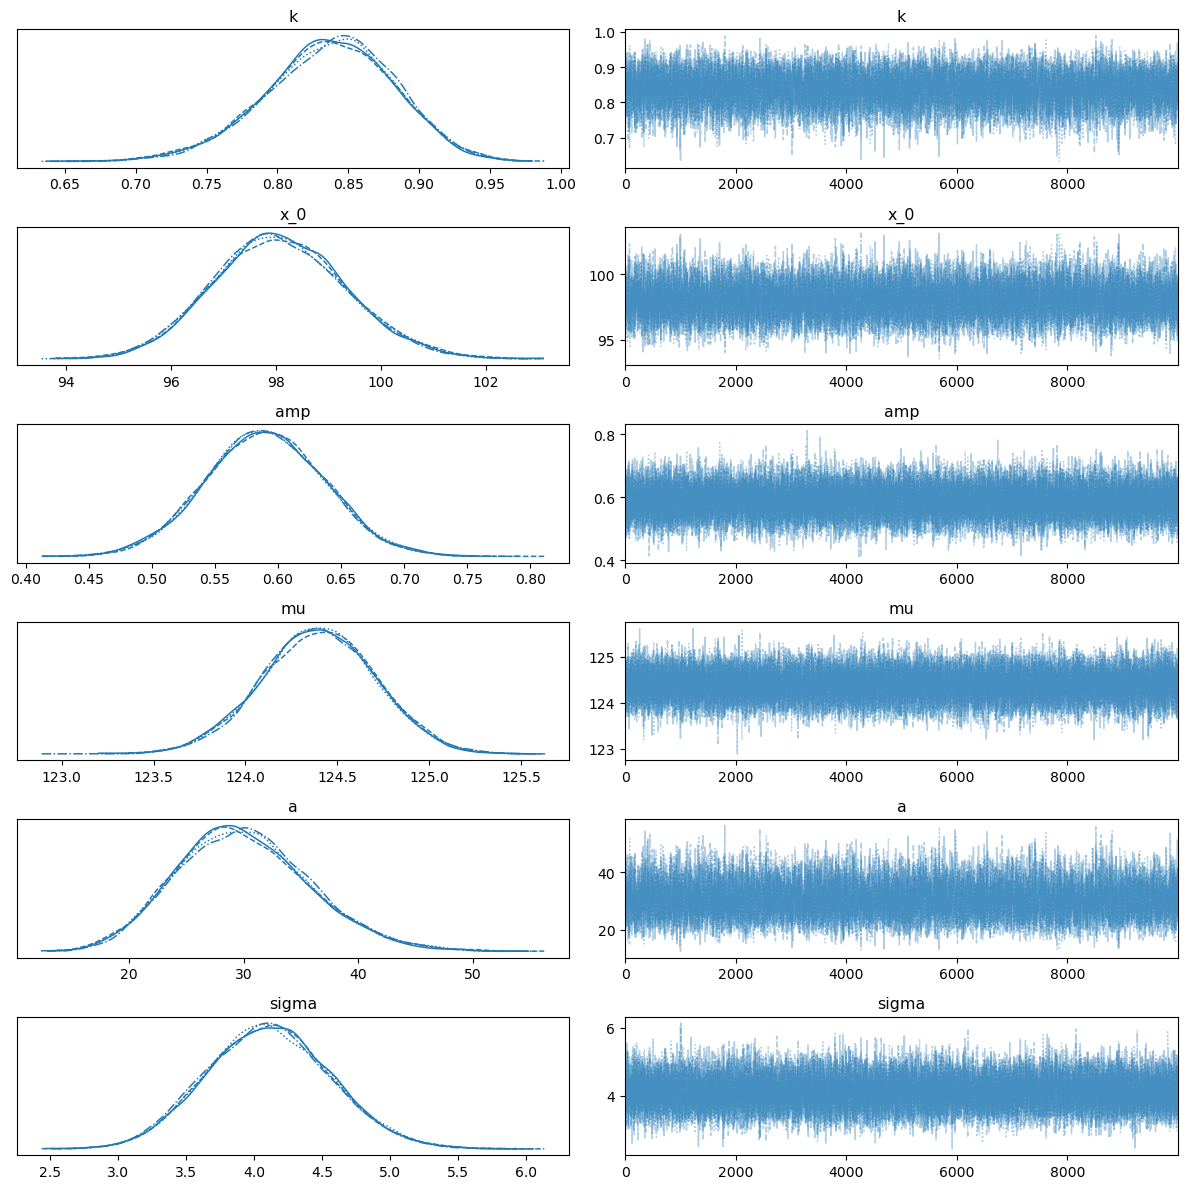

In [ ]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [7]:
post_a = trace.posterior.a.mean().item()
post_k = trace.posterior.k.mean().item()
post_x0 = trace.posterior.x_0.mean().item()
post_mu = trace.posterior.mu.mean().item()
post_sigma = trace.posterior.sigma.mean().item()
post_amp = trace.posterior.amp.mean().item()

post_a, post_k, post_x0, post_mu, post_sigma, post_amp

(30.01070088765202,
 0.8368492882803029,
 98.08508387822583,
 124.39615523675009,
 4.108539080462571,
 0.590015002284631)

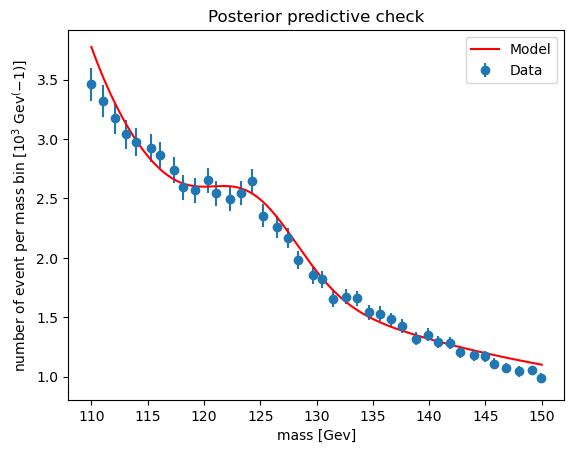

In [8]:
def plot_model(x, a, k, x_0,  mu, sigma, amp):
    powerlaw = a * (x - x_0)**(-k)
    gaussian = amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return powerlaw + gaussian

x = np.linspace(110, 150, 1000)
y = plot_model(x, post_a, post_k, post_x0, post_mu, post_sigma, post_amp)

plt.errorbar(x_values, y_values, yerr=errs_values, fmt='o', label='Data')
plt.plot(x, y, label='Model', color='red')
plt.xlabel('mass [Gev]')
plt.ylabel('number of event per mass bin [$10^3$ Gev$^(-1)$]')
plt.legend()
plt.title('Posterior predictive check')
plt.show()

When the signal is absent, the amplitude parameter of the Gaussian is equal to zero.

We can get the marginalized posterior distribution of each parameter with a corner plot.

Other ways to perform density estimation of a posterior includes Gaussian Mixture Model

#### Corner plot

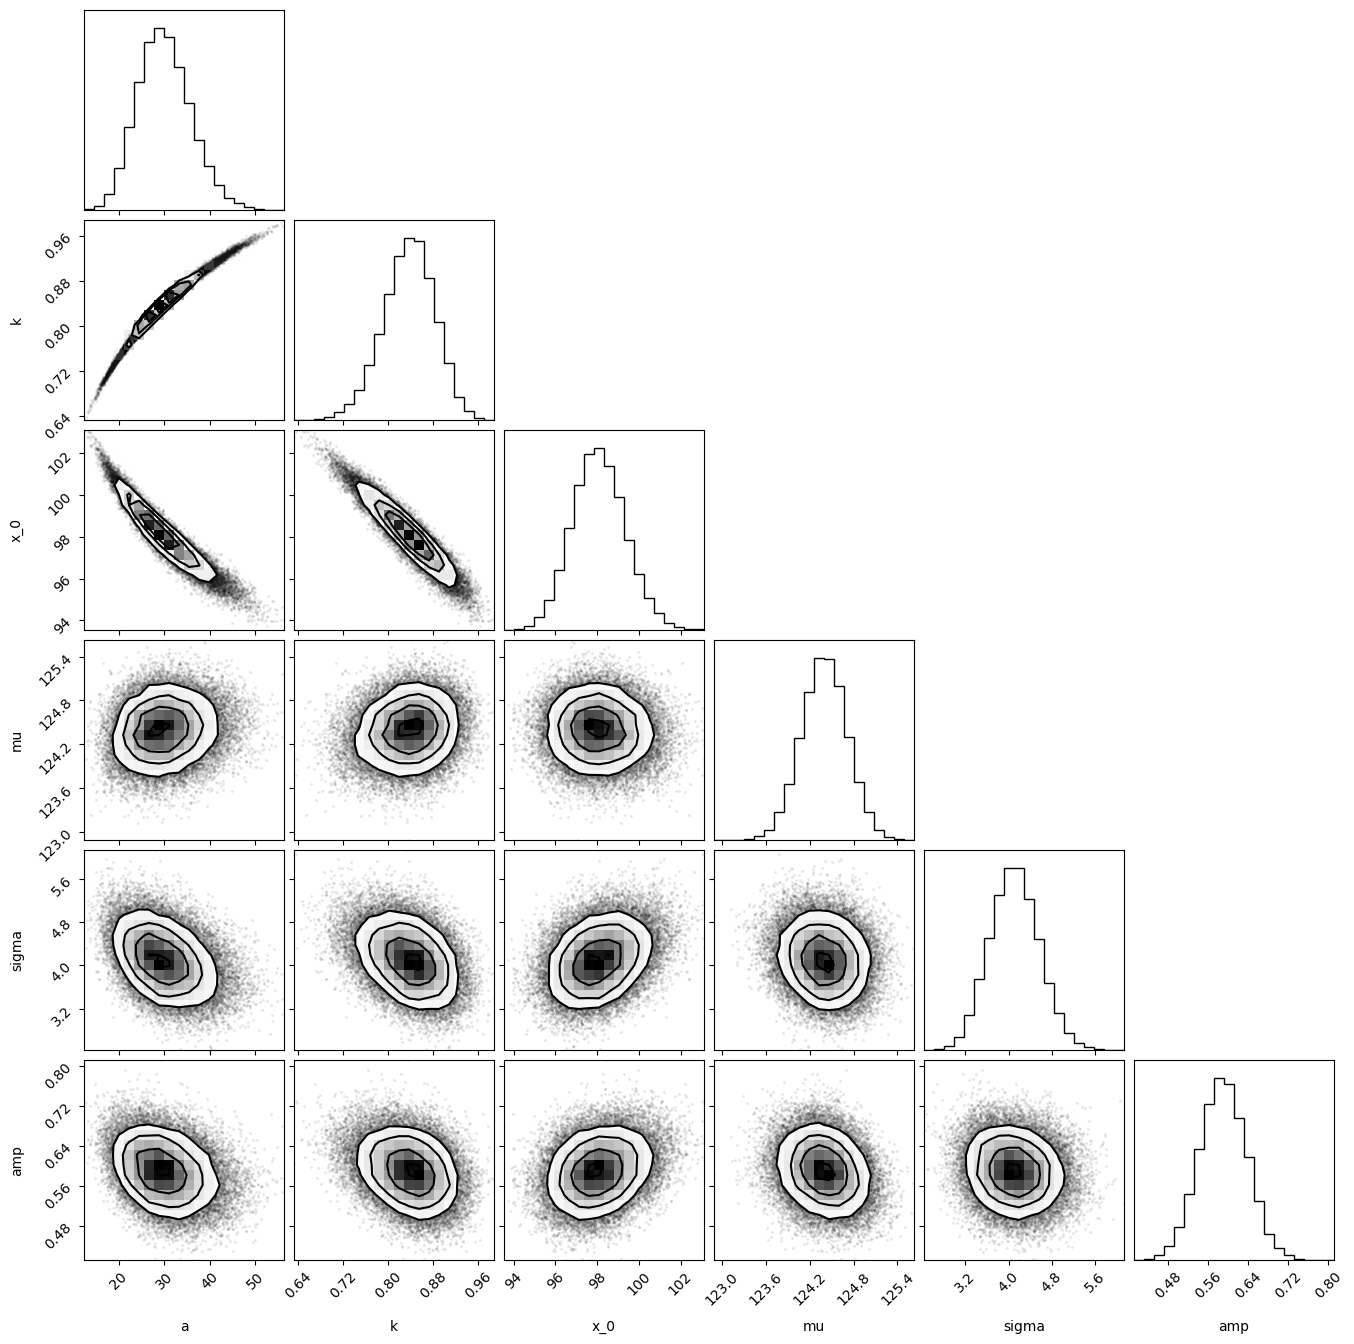

In [ ]:
data = np.column_stack([
    trace.posterior.a.values.flatten(),
    trace.posterior.k.values.flatten(),
    trace.posterior.x_0.values.flatten(),
    trace.posterior.mu.values.flatten(),
    trace.posterior.sigma.values.flatten(),
    trace.posterior.amp.values.flatten(),
])

figure = corner.corner(data, labels=["a", "k", "x_0", "mu", "sigma", "amp"], divergences=True)

#### Gaussian Mixture Model

Actually, we can see how `amp` follows a Gaussian. We can then just set 1 component or 2 in a GMM.

c:\Users\andre\miniforge3\envs\astronomy\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\andre\miniforge3\envs\astronomy\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\andre\miniforge3\envs\astronomy\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\andre\miniforge3\envs\astronomy\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\andre\miniforge3\envs\astronomy\Lib\subpr

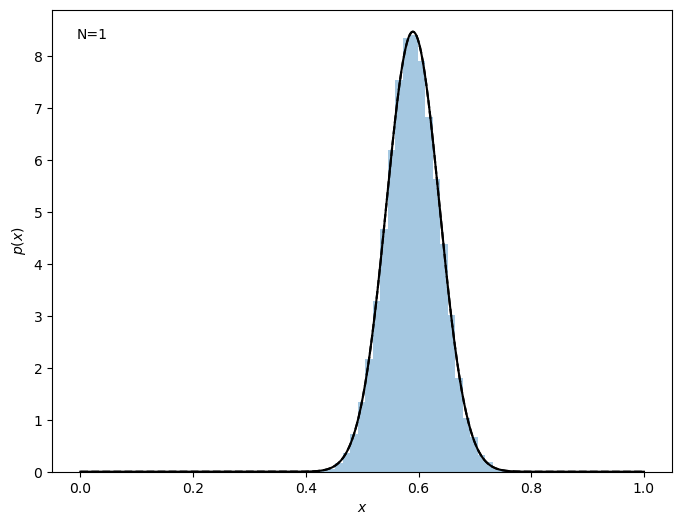

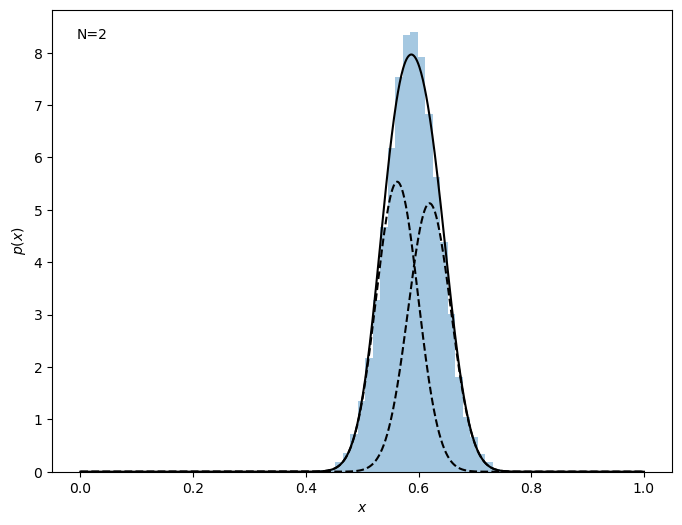

In [10]:
from sklearn.mixture import GaussianMixture

amp = trace.posterior.amp.values.flatten().reshape(-1, 1)

N=[1, 2]

models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(amp)

for M_best,n in zip(models,N):
    
    fig, ax = plt.subplots(figsize=(8, 6))

    x = np.linspace(0, 1, 1000)
    ax.hist(amp, 30, density=True, histtype='stepfilled', alpha=0.4)

    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax.plot(x, pdf, '-k')
    ax.plot(x, pdf_individual, '--k')
    ax.text(0.04, 0.96, "N="+str(n),
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')


The one component GMM is actually better.

### Bayes factor

We need to find the Bayes factor between a model with $\text{amp}\neq 0$ and another model with $\text{amp}=0$. 

In [14]:
from scipy.stats import gaussian_kde
from scipy.stats import norm

# Since amp = pm.Normal("amp", sigma=5)

prior_density_at_0 = norm.pdf(0, loc=0, scale=5)

posterior_density_at_0 = 0
gmm = models[0]
for weight, mean, covar in zip(gmm.weights_, gmm.means_, gmm.covariances_):
    std = np.sqrt(covar.item())
    component_density = norm.pdf(0, loc=mean.item(), scale=std)
    posterior_density_at_0 += weight * component_density

print(f"Prior density at 0: {prior_density_at_0}")
print(f"Posterior density at 0: {posterior_density_at_0}")
print(f"Bayes factor in favor of signal: {prior_density_at_0 / posterior_density_at_0}")

Prior density at 0: 0.07978845608028654
Posterior density at 0: 7.825860449668499e-34
Bayes factor in favor of signal: 1.019548669356433e+32


The gigantic Bayes factor is given by an extremely tight `amp` posterior distribution, and the prior allowed/favored `amp` with value zero. Thus the model with the signal is extremely supported, while `amp=0` is utterly implausible given the data.

According to Jeffrey's scale, if we want to make it official, any Bayes factor above 100 tells us that the evidence in favor of the model 2 (the one with $\text{amp}\neq 0$) is decisive. In our case, well, we have 9.60467537237881e+31, which makes the model 2 quite decisive.